In [1]:
import json
import pandas as pd
from pathlib import Path
from pprint import pprint
import datetime
import time
import numpy as np
import matplotlib as plt

import pandas
import researchpy as rp
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

%matplotlib inline

In [2]:
#path_results = Path('/media/discoD/models/elmo/ner/results_20_epochs_ibm')
#path_results = Path('/media/discoD/models/elmo/ner/results_1_epoch_harem_all_combinations')
#path_results = Path('/opt/models/elmo/ner/results (pre queda energia, datalawyer)')
path_results = Path('/media/discoD/models/elmo/ner/results_embeddings/')

In [3]:
for folder in path_results.iterdir():
    print(folder)

/media/discoD/models/elmo/ner/results_embeddings/datalawyer_Embeddings


In [4]:
configs = dict()
metrics = dict()
for folder in path_results.iterdir():
    results_model_folder = folder.iterdir()
    for training_folder in results_model_folder:
        #print('Reading files from %s' % training_folder.name)
        has_metrics = False
        for results_file in training_folder.iterdir():
            if results_file.name.endswith('.json'):
                #print('Parsing data from %s' % results_file.name)
                if results_file.name.startswith('config'):
                    configs[training_folder.name] = json.loads(results_file.read_bytes())
                elif results_file.name.startswith('metrics.'):
                    metrics[training_folder.name] = json.loads(results_file.read_bytes())
                    has_metrics = True
        if not has_metrics:
            print('"%s"' % training_folder.name)
            del configs[training_folder.name]
print(len(metrics))
print(len(configs))

"datalawyer_Embeddings_glove_s100_6"
36
36


In [5]:
def get_seconds(time_str):
    x = time.strptime(time_str.split('.')[0],'%H:%M:%S')
    return datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()
def get_average_epoch_duration(metrics):
    seconds = get_seconds(metrics['training_duration'])
    training_epochs = metrics['training_epochs'] + 1
    return seconds / training_epochs

In [6]:
TRAINING_ID = 'Training_ID'
SCENARIO = 'Scenario'
MODEL = 'Model'
REPRESENTATION = 'Representation'
EMBEDDING = 'Embedding'
EMBEDDING_TYPE = 'Embedding_Type'
DOMAIN_SPECIFIC = 'Domain_Specific'
DIMENSION = 'Dimension'
EMBEDDING_DIMENSION = 'Embedding_Dimension'
BATCH_SIZE = 'Batch_Size'
ELMO_DROPOUT = 'ELMo_Dropout'
TRAINING_NUMBER = 'Training_Number'
EXECUTION_NUMBER = 'Execution_Number'
BEST_EPOCH = 'Best_Epoch'
TRAINING_EPOCHS = 'Training_Epochs'
TRAINING_DURATION = 'Training_Duration'
TOTAL_DURATION = 'Total_Duration(s)'
AVERAGE_EPOCH_DURATION = 'Average_Epoch_Duration(s)'
TRAINING_ACCURACY = 'Training_Accuracy'
TRAINING_ACCURACY_TOP3 = 'Training_Accuracy_Top-3'
TRAINING_PRECISION = 'Training_Precision'
TRAINING_RECALL = 'Training_Recall'
TRAINING_F1_MEASURE = 'Training_F1-Measure'
TRAINING_LOSS = 'Training_Loss'
BEST_VALIDATION_ACCURACY = 'Best_Validation_Accuracy'
BEST_VALIDATION_ACCURACY_TOP3 = 'Best_Validation_Accuracy_Top-3'
BEST_VALIDATION_PRECISION = 'Best_Validation_Precision'
BEST_VALIDATION_RECALL = 'Best_Validation_Recall'
BEST_VALIDATION_F1_MEASURE = 'Best_Validation_F1-Measure'
BEST_VALIDATION_LOSS = 'Best_Validation_Loss'
TEST_ACCURACY = 'Test_Accuracy'
TEST_ACCURACY_TOP3 = 'Test_Accuracy_Top-3'
TEST_PRECISION = 'Test_Precision'
TEST_RECALL = 'Test_Recall'
TEST_F1_MEASURE = 'Test_F1_Measure'
TEST_LOSS = 'Test_Loss'
columns = [TRAINING_ID, MODEL, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE, DOMAIN_SPECIFIC, DIMENSION, EMBEDDING_DIMENSION, EXECUTION_NUMBER, BEST_EPOCH, TRAINING_EPOCHS, TRAINING_DURATION, TOTAL_DURATION, AVERAGE_EPOCH_DURATION, TRAINING_ACCURACY, TRAINING_ACCURACY_TOP3, TRAINING_PRECISION, TRAINING_RECALL, TRAINING_F1_MEASURE, TRAINING_LOSS, BEST_VALIDATION_ACCURACY, BEST_VALIDATION_ACCURACY_TOP3, BEST_VALIDATION_PRECISION, BEST_VALIDATION_RECALL, BEST_VALIDATION_F1_MEASURE, BEST_VALIDATION_LOSS, TEST_ACCURACY, TEST_ACCURACY_TOP3, TEST_PRECISION, TEST_RECALL, TEST_F1_MEASURE, TEST_LOSS]
columns

['Training_ID',
 'Model',
 'Representation',
 'Embedding',
 'Embedding_Type',
 'Domain_Specific',
 'Dimension',
 'Embedding_Dimension',
 'Execution_Number',
 'Best_Epoch',
 'Training_Epochs',
 'Training_Duration',
 'Total_Duration(s)',
 'Average_Epoch_Duration(s)',
 'Training_Accuracy',
 'Training_Accuracy_Top-3',
 'Training_Precision',
 'Training_Recall',
 'Training_F1-Measure',
 'Training_Loss',
 'Best_Validation_Accuracy',
 'Best_Validation_Accuracy_Top-3',
 'Best_Validation_Precision',
 'Best_Validation_Recall',
 'Best_Validation_F1-Measure',
 'Best_Validation_Loss',
 'Test_Accuracy',
 'Test_Accuracy_Top-3',
 'Test_Precision',
 'Test_Recall',
 'Test_F1_Measure',
 'Test_Loss']

In [7]:
def get_training_data_from_id(training_id, config):
    data = training_id.split('_')
    print(data)
#     if len(data) == 3:
#         return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: 'No', EMBEDDING_TYPE: 'No', DOMAIN_SPECIFIC: False, EXECUTION_NUMBER: data[2]}
#     elif len(data) == 4:
#         #GloVe
#         return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: 'No', DOMAIN_SPECIFIC: False, EXECUTION_NUMBER: data[3]}
    if len(data) == 5:
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: 'No', DOMAIN_SPECIFIC: False, DIMENSION: data[3][-3:], EXECUTION_NUMBER: data[4]}
#     elif len(data) == 6:
#         return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: 'No', DOMAIN_SPECIFIC: True, EXECUTION_NUMBER: data[5]}
    elif len(data) == 7:
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: data[4], DOMAIN_SPECIFIC: True, DIMENSION: data[5][-3:], EXECUTION_NUMBER: data[6]}
    elif len(data) == 8:
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: data[4], DOMAIN_SPECIFIC: True, DIMENSION: data[6][-3:], EXECUTION_NUMBER: data[7]}
    else:
        print('Check id: %s' % training_id)

In [8]:
training_data = []
for training_id, config in configs.items():
    training_metrics = metrics[training_id]
    data = get_training_data_from_id(training_id, config)
    if '-lc' in data[EMBEDDING]:
        data[EMBEDDING] = data[EMBEDDING].replace('-lc', '')
        data[DOMAIN_SPECIFIC] = True
    data[EMBEDDING_DIMENSION] = data[EMBEDDING_TYPE] + '_' + data[DIMENSION]
    data[DOMAIN_SPECIFIC] = 'Sim' if data[DOMAIN_SPECIFIC] else 'Não'
    data[TRAINING_ID] = training_id
    data[BEST_EPOCH] = training_metrics['best_epoch'] if training_metrics else None
    data[TRAINING_EPOCHS] = training_metrics['training_epochs'] + 1 if training_metrics else None
    data[TRAINING_DURATION] = training_metrics['training_duration'] if training_metrics else None
    data[TOTAL_DURATION] = get_seconds(training_metrics['training_duration']) if training_metrics else None
    data[AVERAGE_EPOCH_DURATION] = get_average_epoch_duration(training_metrics) if training_metrics else None
    data[TRAINING_ACCURACY] = training_metrics['training_accuracy'] if training_metrics else None
    data[TRAINING_ACCURACY_TOP3] = training_metrics['training_accuracy3'] if training_metrics else None
    data[TRAINING_PRECISION] = training_metrics['training_precision-overall'] if training_metrics else None
    data[TRAINING_RECALL] = training_metrics['training_recall-overall'] if training_metrics else None
    data[TRAINING_F1_MEASURE] = training_metrics['training_f1-measure-overall'] if training_metrics else None
    data[TRAINING_LOSS] = training_metrics['training_loss'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY] = training_metrics['best_validation_accuracy'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY_TOP3] = training_metrics['best_validation_accuracy3'] if training_metrics else None
    data[BEST_VALIDATION_PRECISION] = training_metrics['best_validation_precision-overall'] if training_metrics else None
    data[BEST_VALIDATION_RECALL] = training_metrics['best_validation_recall-overall'] if training_metrics else None
    data[BEST_VALIDATION_F1_MEASURE] = training_metrics['best_validation_f1-measure-overall'] if training_metrics else None
    data[BEST_VALIDATION_LOSS] = training_metrics['best_validation_loss'] if training_metrics else None
    data[TEST_ACCURACY] = training_metrics['test_accuracy'] if training_metrics else None
    data[TEST_ACCURACY_TOP3] = training_metrics['test_accuracy3'] if training_metrics else None
    data[TEST_PRECISION] = training_metrics['test_precision-overall'] if training_metrics else None
    data[TEST_RECALL] = training_metrics['test_recall-overall'] if training_metrics else None
    data[TEST_F1_MEASURE] = training_metrics['test_f1-measure-overall'] if training_metrics else None
    data[TEST_LOSS] = training_metrics['test_loss'] if training_metrics else None
    training_data.append(data)

['datalawyer', 'Embeddings', 'glove-lc', 'jur', '5B-jur2vec-nilc-2', 's100', '0']
['datalawyer', 'Embeddings', 'glove-lc', 'jur', '10B-jur2vec-nilc-brwac', 'win-15', 's100', '0']
['datalawyer', 'Embeddings', 'glove-lc', 'jur', '10B-jur2vec-nilc-brwac', 'win-15', 's100', '1']
['datalawyer', 'Embeddings', 'glove-lc', 'jur', '10B-jur2vec-nilc-brwac', 'win-15', 's100', '2']
['datalawyer', 'Embeddings', 'glove-lc', 'jur', '10B-jur2vec-nilc-brwac', 'win-15', 's100', '3']
['datalawyer', 'Embeddings', 'glove-lc', 'jur', '10B-jur2vec-nilc-brwac', 'win-15', 's100', '4']
['datalawyer', 'Embeddings', 'glove-lc', 'jur', '10B-jur2vec-nilc-brwac', 'win-15', 's100', '5']
['datalawyer', 'Embeddings', 'glove-lc', 'jur', '10B-jur2vec-nilc-brwac', 'win-15', 's300', '0']
['datalawyer', 'Embeddings', 'glove-lc', 'jur', '10B-jur2vec-nilc-brwac', 'win-15', 's300', '1']
['datalawyer', 'Embeddings', 'glove-lc', 'jur', '10B-jur2vec-nilc-brwac', 'win-15', 's300', '2']
['datalawyer', 'Embeddings', 'glove-lc', 'jur

In [9]:
pd.set_option('display.max_columns', 1000)
training_data_df = pd.DataFrame(training_data, columns=columns)
#training_data_df = training_data_df[(training_data_df[EXECUTION_NUMBER]).astype(int) < 1]
training_data_df

,Training_ID,Model,Representation,Embedding,Embedding_Type,Domain_Specific,Dimension,Embedding_Dimension,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
0,datalawyer_Embeddings_glove-lc_jur_5B-jur2vec-...,datalawyer,Embeddings,glove,5B-jur2vec-nilc-2,Sim,100,5B-jur2vec-nilc-2_100,0,9,10,0:08:45.085900,525.0,52.5,0.982840,0.983359,0.822213,0.778511,0.799765,202.395641,0.981777,0.982129,0.849290,0.810253,0.829312,210.974617,0.982273,0.982805,0.857231,0.815882,0.836046,199.322855
1,datalawyer_Embeddings_glove-lc_jur_10B-jur2vec...,datalawyer,Embeddings,glove,10B-jur2vec-nilc-brwac,Sim,100,10B-jur2vec-nilc-brwac_100,0,9,10,0:08:46.661675,526.0,52.6,0.984344,0.984855,0.832163,0.796905,0.814152,190.453895,0.982065,0.982337,0.842449,0.835003,0.838710,204.960891,0.983244,0.983713,0.856019,0.832353,0.844020,187.617743
2,datalawyer_Embeddings_glove-lc_jur_10B-jur2vec...,datalawyer,Embeddings,glove,10B-jur2vec-nilc-brwac,Sim,100,10B-jur2vec-nilc-brwac_100,1,9,10,0:08:37.186416,517.0,51.7,0.984525,0.985022,0.833400,0.797666,0.815141,189.850776,0.982273,0.982545,0.845238,0.836771,0.840983,206.758420,0.983400,0.983854,0.862888,0.832941,0.847650,187.695175
3,datalawyer_Embeddings_glove-lc_jur_10B-jur2vec...,datalawyer,Embeddings,glove,10B-jur2vec-nilc-brwac,Sim,100,10B-jur2vec-nilc-brwac_100,2,9,10,0:08:59.227556,539.0,53.9,0.984197,0.984712,0.831855,0.797032,0.814071,191.857660,0.982417,0.982689,0.845330,0.837360,0.841326,203.298045,0.983306,0.983745,0.863581,0.834118,0.848594,186.856262
4,datalawyer_Embeddings_glove-lc_jur_10B-jur2vec...,datalawyer,Embeddings,glove,10B-jur2vec-nilc-brwac,Sim,100,10B-jur2vec-nilc-brwac_100,3,9,10,0:08:48.678096,528.0,52.8,0.984054,0.984569,0.830508,0.795636,0.812698,191.446179,0.982257,0.982513,0.837046,0.841485,0.839259,201.148832,0.983886,0.984324,0.860759,0.840000,0.850253,185.014575
5,datalawyer_Embeddings_glove-lc_jur_10B-jur2vec...,datalawyer,Embeddings,glove,10B-jur2vec-nilc-brwac,Sim,100,10B-jur2vec-nilc-brwac_100,4,9,10,0:08:37.022117,517.0,51.7,0.984378,0.984889,0.833245,0.798046,0.815266,190.862792,0.981761,0.982001,0.832155,0.832646,0.832401,205.474005,0.983760,0.984136,0.860676,0.839412,0.849911,185.314456
6,datalawyer_Embeddings_glove-lc_jur_10B-jur2vec...,datalawyer,Embeddings,glove,10B-jur2vec-nilc-brwac,Sim,100,10B-jur2vec-nilc-brwac_100,5,9,10,0:08:37.367869,517.0,51.7,0.984436,0.984937,0.833885,0.799188,0.816168,189.590487,0.981633,0.981905,0.835803,0.830878,0.833333,204.779849,0.983760,0.984168,0.861985,0.837647,0.849642,186.907852
7,datalawyer_Embeddings_glove-lc_jur_10B-jur2vec...,datalawyer,Embeddings,glove,10B-jur2vec-nilc-brwac,Sim,300,10B-jur2vec-nilc-brwac_300,0,8,10,0:08:46.449816,526.0,52.6,0.992298,0.992520,0.916828,0.901941,0.909323,98.430616,0.984721,0.984833,0.873804,0.860931,0.867320,200.420247,0.985671,0.985890,0.880357,0.870000,0.875148,198.890992
8,datalawyer_Embeddings_glove-lc_jur_10B-jur2vec...,datalawyer,Embeddings,glove,10B-jur2vec-nilc-brwac,Sim,300,10B-jur2vec-nilc-brwac_300,1,9,10,0:08:48.239365,528.0,52.8,0.992438,0.992666,0.917515,0.903083,0.910242,97.406772,0.985201,0.985425,0.872391,0.862110,0.867220,189.567143,0.986203,0.986595,0.883721,0.871765,0.877702,202.989664
9,datalawyer_Embeddings_glove-lc_jur_10B-jur2vec...,datalawyer,Embeddings,glove,10B-jur2vec-nilc-brwac,Sim,300,10B-jur2vec-nilc-brwac_300,2,9,10,0:09:02.739000,542.0,54.2,0.992284,0.992492,0.916280,0.902448,0.909312,97.999523,0.984545,0.984737,0.865362,0.859753,0.862548,188.358306,0.986798,0.987002,0.889745,0.882941,0.886330,199.634957


In [10]:
training_data_df.to_csv('training_data_10_epochs_embeddings_datalawyer.csv', index=None)

In [11]:
str(datetime.timedelta(seconds=training_data_df[TOTAL_DURATION].mean()))

'0:08:44.694444'

In [12]:
default_exported_columns = ['mean', 'min', 'max', 'std']
renamed_columns = ['Contagem', 'F-Score', 'Desvio Padrão', 'Mínimo', '25%', '50%', '75%', 'Máximo']
exported_columns_names = ['F-Score', 'Mínimo', 'Máximo', 'Desvio Padrão']
model_map = {'datalawyer-ft': 'Sim', 'datalawyer': 'Não', 'datalawyer-pt': 'Geral'}
representation_map = {'ELMo+CNN+Embeddings': 'ELMo+CNN+Vetor', 'ELMo+Embeddings': 'ELMo+Vetor', 'ELMo-pt+CNN+Embeddings': 'ELMo+CNN+Vetor', 'ELMo-pt+Embeddings': 'ELMo+Vetor', 'ELMo-pt': 'ELMo', 'ELMo-pt+CNN': 'ELMo+CNN'}
embedding_type_map = {'skip': 'Skip-Gram', 'No': 'Normal', 'cbow': 'CBoW'}
embedding_map = {'wang2vec': 'Wang2Vec', 'glove': 'GloVe', 'word2vec': 'Word2Vec', 'No': 'Sem Vetor', 'fasttext': 'FastText', 'wang2vec-lc': 'Wang2Vec', 'glove-lc': 'GloVe', 'word2vec-lc': 'Word2Vec', 'fasttext-lc': 'FastText'}
replacements_map = {**model_map, **representation_map, **embedding_type_map, **embedding_map}

def get_group_csv(index_names, group_name, group_columns, target_value, index_map, dataframe=training_data_df, exported_columns=default_exported_columns):
    dataframe = dataframe.rename(index={'ELMo-pt+CNN+Embeddings': 'ELMo+CNN+Vetor', 'ELMo-pt+Embeddings': 'ELMo+Vetor', 'ELMo-pt': 'ELMo', 'ELMo-pt+CNN': 'ELMo+CNN'})
    if type(index_names) == str:
        index_names = [index_names]
    group = dataframe.groupby(group_columns).describe()[target_value].sort_values(by='mean', ascending=False)
    for column in exported_columns:
        group[column] = group[column] * 100
    group.index.names = index_names
    group = group.rename(index=index_map)
    group.columns = renamed_columns
    group.to_csv('grupo_' + group_name + '_10_epochs_embeddings_datalawyer.csv', columns=exported_columns_names, float_format = '%.2f%%')
    return group

In [13]:
get_group_csv('Ajuste Fino', DOMAIN_SPECIFIC, DOMAIN_SPECIFIC, TEST_F1_MEASURE, model_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Ajuste Fino,,,,,,,,
Sim,30.0,85.061316,1.547329,83.549653,0.839958,0.847327,0.850690,88.633009
Não,6.0,81.327592,0.149500,81.138359,0.812188,0.813256,0.814294,81.528662


In [14]:
get_group_csv('Representação', REPRESENTATION, REPRESENTATION, TEST_F1_MEASURE, representation_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Representação,,,,,,,,
Embeddings,36.0,84.439029,1.99462,81.138359,0.835902,0.843296,0.849996,88.633009


In [15]:
get_group_csv('Tipo de Vetor', EMBEDDING_TYPE, EMBEDDING_TYPE, TEST_F1_MEASURE, embedding_type_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Tipo de Vetor,,,,,,,,
10B-jur2vec-nilc-brwac,12.0,86.363774,1.634410,84.402028,0.849380,0.861867,0.878353,88.633009
5B-jur2vec-nilc-1,6.0,84.939689,0.244694,84.688995,0.847427,0.849172,0.850537,85.330948
5B-jur2vec-nilc-3,6.0,83.954831,0.294835,83.554768,0.837267,0.840695,0.841417,84.257075
5B-jur2vec-nilc-2,6.0,83.684514,0.172865,83.549653,0.835703,0.836024,0.837635,83.975904
Normal,6.0,81.327592,0.149500,81.138359,0.812188,0.813256,0.814294,81.528662


In [16]:
get_group_csv('Dimensão', DIMENSION, DIMENSION, TEST_F1_MEASURE, embedding_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Dimensão,,,,,,,,
300,6.0,87.893048,0.458241,87.348148,0.875786,0.879004,0.880538,88.633009
100,30.0,83.748225,1.342927,81.138359,0.835562,0.840695,0.848358,85.330948


In [17]:
get_group_csv('Vetor', EMBEDDING, EMBEDDING, TEST_F1_MEASURE, embedding_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Vetor,,,,,,,,
GloVe,36.0,84.439029,1.99462,81.138359,0.835902,0.843296,0.849996,88.633009


In [18]:
get_group_csv(['Vetor', 'Domínio Específico'], 'Emb_Dom', [EMBEDDING, DOMAIN_SPECIFIC], TEST_F1_MEASURE, replacements_map)

Contagem    F-Score  Desvio Padrão     Mínimo  \
Vetor Domínio Específico                                                  
GloVe Sim                     30.0  85.061316       1.547329  83.549653   
      Não                      6.0  81.327592       0.149500  81.138359   

                               25%       50%       75%     Máximo  
Vetor Domínio Específico                                           
GloVe Sim                 0.839958  0.847327  0.850690  88.633009  
      Não                 0.812188  0.813256  0.814294  81.528662

In [19]:
get_group_csv(['Ajuste Fino', 'Representação', 'Vetor', 'Tipo de Vetor', 'Domínio Específico', 'Dimensão'], 'Model_Rep_Emb_Emb-Typ_Dom_Dim', [DOMAIN_SPECIFIC, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE, DOMAIN_SPECIFIC, DIMENSION], TEST_F1_MEASURE, replacements_map)

Contagem  \
Ajuste Fino Representação Vetor Tipo de Vetor          Domínio Específico Dimensão             
Sim         Embeddings    GloVe 10B-jur2vec-nilc-brwac Sim                300            6.0   
                                5B-jur2vec-nilc-1      Sim                100            6.0   
                                10B-jur2vec-nilc-brwac Sim                100            6.0   
                                5B-jur2vec-nilc-3      Sim                100            6.0   
                                5B-jur2vec-nilc-2      Sim                100            6.0   
Não         Embeddings    GloVe Sem Vetor              Não                100            6.0   

                                                                                      F-Score  \
Ajuste Fino Representação Vetor Tipo de Vetor          Domínio Específico Dimensão              
Sim         Embeddings    GloVe 10B-jur2vec-nilc-brwac Sim                300       87.893048   
                                5B-jur2vec-nilc-1      Sim                100       84.939689   
                                10B-jur2vec-nilc-brwac Sim                100       84.834501   
                                5B-jur2vec-nilc-3      Sim                100       83.954831   
                                5B-jur2vec-nilc-2      Sim                100       83.684514   
Não         Embeddings    GloVe Sem Vetor              Não                100       81.327592   

                                                                                    Desvio Padrão  \
Ajuste Fino Representação Vetor Tipo de Vetor          Domínio Específico Dimensão                  
Sim         Embeddings    GloVe 10B-jur2vec-nilc-brwac Sim                300            0.458241   
                                5B-jur2vec-nilc-1      Sim                100            0.244694   
                                10B-jur2vec-nilc-brwac Sim                100            0.232472   
                                5B-jur2vec-nilc-3      Sim                100            0.294835   
                                5B-jur2vec-nilc-2      Sim                100            0.172865   
Não         Embeddings    GloVe Sem Vetor              Não                100            0.149500   

                                                                                       Mínimo  \
Ajuste Fino Representação Vetor Tipo de Vetor          Domínio Específico Dimensão              
Sim         Embeddings    GloVe 10B-jur2vec-nilc-brwac Sim                300       87.348148   
                                5B-jur2vec-nilc-1      Sim                100       84.688995   
                                10B-jur2vec-nilc-brwac Sim                100       84.402028   
                                5B-jur2vec-nilc-3      Sim                100       83.554768   
                                5B-jur2vec-nilc-2      Sim                100       83.549653   
Não         Embeddings    GloVe Sem Vetor              Não                100       81.138359   

                                                                                         25%  \
Ajuste Fino Representação Vetor Tipo de Vetor          Domínio Específico Dimensão             
Sim         Embeddings    GloVe 10B-jur2vec-nilc-brwac Sim                300       0.875786   
                                5B-jur2vec-nilc-1      Sim                100       0.847427   
                                10B-jur2vec-nilc-brwac Sim                100       0.847886   
                                5B-jur2vec-nilc-3      Sim                100       0.837267   
                                5B-jur2vec-nilc-2      Sim                100       0.835703   
Não         Embeddings    GloVe Sem Vetor              Não                100       0.812188   

                                                                                         50%  \
Ajuste Fino Representação Vetor Tipo de Vetor          Domínio Específico Dimensão     

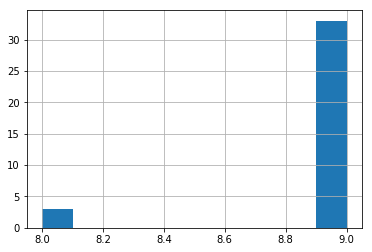

In [20]:
training_data_df[BEST_EPOCH].hist()

In [21]:
training_data_df[TOTAL_DURATION].describe()

count     36.000000
mean     524.694444
std       10.186320
min      512.000000
25%      517.000000
50%      522.000000
75%      528.500000
max      555.000000
Name: Total_Duration(s), dtype: float64

In [22]:
training_data_df.groupby([EXECUTION_NUMBER]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Execution_Number,,,,,,,,
2,6.0,0.846601,0.023442,0.813672,0.840222,0.845102,0.849380,0.886330
3,6.0,0.845816,0.021440,0.814502,0.838832,0.845544,0.850690,0.880307
5,6.0,0.844850,0.021342,0.815287,0.837139,0.843778,0.848982,0.880615
4,6.0,0.843408,0.020719,0.811971,0.835746,0.843041,0.852460,0.873481
0,6.0,0.842919,0.020039,0.812841,0.837677,0.843296,0.846173,0.875148
1,6.0,0.842747,0.021769,0.811384,0.835509,0.841599,0.848439,0.877702


In [23]:
rp.summary_cont(training_data_df[TEST_F1_MEASURE])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Test_F1_Measure,36.0,0.84439,0.019946,0.003324,0.837641,0.851139


In [24]:
rp.summary_cont(training_data_df.groupby(EMBEDDING))[TEST_F1_MEASURE]

,N,Mean,SD,SE,95% Conf.,Interval
Embedding,,,,,,
glove,36,0.84439,0.019946,0.003324,0.837875,0.850906


In [25]:
# Calculating effect size
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

def print_anova(parameter):
    # Fits the model with the interaction term
    # This will also automatically include the main effects for each factor
    model = ols('Test_F1_Measure ~ C({0})'.format(parameter), training_data_df).fit()
    # Seeing if the overall model is significant
    print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .20f}")
    print(model.summary())
    res = sm.stats.anova_lm(model, typ= 2)
    print(res)
    print(anova_table(res))
    mc = statsmodels.stats.multicomp.MultiComparison(training_data_df[TEST_F1_MEASURE], training_data_df[parameter])
    mc_results = mc.tukeyhsd()
    print(mc_results)

In [26]:
print_anova(EMBEDDING_DIMENSION)

Overall model F( 5, 30) =  354.852, p =  0.00000000000000000000
                            OLS Regression Results                            
Dep. Variable:        Test_F1_Measure   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     354.9
Date:                Thu, 19 Sep 2019   Prob (F-statistic):           9.88e-26
Time:                        14:43:30   Log-Likelihood:                 164.10
No. Observations:                  36   AIC:                            -316.2
Df Residuals:                      30   BIC:                            -306.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------